# Tomographic reconstrution

The goal of this assignment is to implement a tomographic reconstruction, first in 2D and then in 3D.
You can use numpy and any library you want to open the images, but no library that do all or part of the reconstruction.

This notebook come with two folders : <br>
&nbsp;&nbsp;&nbsp;./&nbsp;+<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|--AR_Assignment3.ipynb<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|--data/\*<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|--notebook_images/\*<br>
 


## I) Parallel 2D reconstruction (3pts)

The first step will be to reconstruct a 2D image from 1D projections.

The reconstructions algorithms are based on two function : the projection and the backprojection.

The projection is the process done when capturing a radiograph. It reduce the dimension of an object by one (2D->1D or 3D->2D). 

The backprojection is the inverse operation of the projection : it take a projected data and propagate it into a higher dimension object (1D->2D, 2D->3D). Of course, a lot of information is lost in the projection process, so the result of the backprojection carry a lot less information than the original object. In order to obtain a better approximation, a lot of projections at different positions are needed.

For both the projection and the backprojection, you need to link which voxel is linked with which pixels. From a backprojection perspective, it's better to start at each pixel and determine which voxels are projected to this pixel. It can be done by tracing a discrete path in the volume, with the start and end of this path depending on the geometry of the aquisition.

So, you need to compute for each pixels of the projected data the path in the reconstructed object between the pixel and the source, and add to all element in this path the value of the pixel divided by the length of the path.

For an improved image quality, the path can be also weighted (anti-aliased) to produce a smoother result. In this assignment, you are not asked to do that and can consider all elements in the path to have a weigth of 1.

<img src="notebook_images/projection_2d_par.jpg" alt="Projection 2D parallel" style="height: 20em;"/>

In the case of a parallel geometry, the voxels have the same size as the pixels, and the distances between the source, the object and the detector don't impact the result.

**Step 1.0 :** Write a function that take two 2D points in a grid as argument and return the list of all the cells (coordinates) that are in the path between them.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def get_cells(p1,p2):
    pts=[]
    x0, y0 = p1
    x1, y1 = p2
    
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    x, y = x0, y0
    sx = -1 if x0 > x1 else 1
    sy = -1 if y0 > y1 else 1
    if dx > dy:
        err = dx / 2.0
        while x != x1:
            pts.append([x, y])
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else:
        err = dy / 2.0
        while y != y1:
            pts.append([x, y])
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy        
    pts.append([x, y])
    return pts

**Step 1.1 :** Create a numpy array of size 80 by 80 filled with zeros. Using the previous function, fill the path from \[3,5\] to \[70,75\] with ones and display the result  with gnuplot.

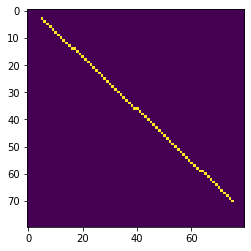

In [4]:
arr=np.zeros([80,80])
pathCor=get_cells([3,5],[70,75])
for point in pathCor:
    arr[point[0],point[1]]=1
plt.imshow(arr)
plt.show()

**Step 1.2 :** Write a function that take as argument a coordinate on a sinogram line and the angle of this line (and possibly other parameters to represent the geometry) and return the start and end of the path between this pixel and the source in a parallel geometry.

In [5]:
def draw_line(point,angle,xlim = 100, ylim = 100):
    
    x,y = point
    
    if angle % 180 == 0:
        point_end = [-xlim,y]
        point_start = [xlim,y]

    elif angle==90 and angle==270:
        point_end = [x,-ylim]
        point_start = [x,y]
    else:

        m = np.tan((angle))
    
        c = y - m*x
        # print(m)
        if abs(m)<=1:
            x2 = xlim
            # print(x2)
            point_end = [x2,np.round(m*x2 +c)]
            point_start = [-x2,np.round(-m*x2 +c)]
        else:
            y2 = ylim
            # print(x2)
            point_end = [np.round((y2-c)/m),y2]
            point_start = [np.round((-y2-c)/m),-y2]
            
    return point_start,point_end

In [6]:
p = [0,0]
angle = 180
[p1,p2] = draw_line(p,angle)
print(p1,p2)

[100, 0] [-100, 0]


Step 1.3 : Create a function that take as argument a sinogram and the needed parameters, and output the result of the 2D backprojection. You should use the previous functions.

In [59]:
 from IPython import display
 def add_offset(point,offset):
    x1, y1 = point
    x1+=offset
    y1+=offset
    return [x1,y1]
 
 
 def reconstruct(sinogram,phantom_size=[100,100]):
    detector_len = sinogram.shape[1]
    phantom =np.zeros(phantom_size)
    for i in range(sinogram.shape[0]):
        angle_step = np.deg2rad(360/sinogram.shape[0])*i
        for element in range(detector_len):
            dis = np.floor((detector_len/2)-element)
            
            point = [np.round(dis*np.cos(angle_step+np.pi/2)),np.round(dis*np.sin(angle_step+np.pi/2))]

            point_start,point_end = draw_line(point,angle_step,phantom_size[0]/2-50,phantom_size[1]/2-50)
          
            pathCor=get_cells(add_offset(point_start,phantom_size[0]/2-45),add_offset(point_end,phantom_size[0]/2-45))
            for p in pathCor:
                phantom[int(p[0]),int(p[1])]+=sinogram[i,element]
                
    return phantom[5:phantom_size[0]-95,5:phantom_size[1]-95]


(200, 128)


**Step 1.4 :** Open the tiff file "data/sinogram_2d_parallel.tif" and display it. Each line of the sinogram represent the projection of the image at a given angle.

The parameters of this projection are the following :
 - Parallel aqcuisition geometry
 - 200 projections over 360 degrees (with a regular step)

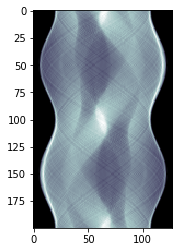

In [107]:
from PIL import Image
im = Image.open("data/sinogram_2d_parallel.tif")
sinogram = np.array(im)
plt.imshow(sinogram,cmap=plt.cm.bone)


**Step 1.5 :** Apply the parallel reconstruction function to the parallel sinogram and display the result

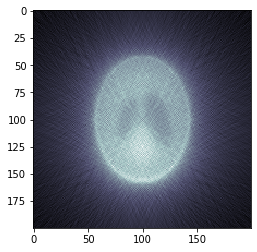

In [71]:
phantom_size=300
reconstruction = reconstruct(sinogram,[phantom_size,phantom_size])
plt.imshow(reconstruction,cmap=plt.cm.bone)
plt.show()

## 2) Spherical 2D reconstruction (3pts)

The parallel geometry is simpler to reconstruct, but in practice not used so often because of the complexity of the parallel x-ray generation. A much more common approach is to use a ponctual source, that create a spherical geometry. 

The path come from the source and go to a pixel on the detector. In 2D, it can be simplifies as a fan-beam when the source and the detector are aligned.

<img src="notebook_images/projection_2d_cone.jpg" alt="Projection 2D spherical" style="height: 20em;"/>

**Step 2.0 :** Write a function that take as argument a coordinate on a sinogram line and the angle of this line (and possibly other parameters to represent the geometry) and return the start and end of the path between this pixel and the source in a spherical geometry.

In [73]:
# We have designed a Generric Function that work for both geometry.

**Step 2.1 :** Create a function that take as argument a sinogram and the needed parameters, and output the result of the 2D spherical back-projection. You should use the previous functions.

In [74]:
 import math
 from IPython import display

 def add_offset(point,offset):
    x1, y1 = point
    x1+=offset
    y1+=offset
    return [x1,y1]
 
 
 def reconstruct_sp(sinogram,phantom_size=[100,100]):
    SO=300
    OD=100
    detector_len = sinogram.shape[1]
    phantom =np.zeros(phantom_size)
    for i in range(sinogram.shape[0]):
        angle_step = np.deg2rad(360/sinogram.shape[0])*i

        for element in range(detector_len):
        
            dis = np.floor((detector_len/2)-element)

            source_point=[np.round(-SO*np.cos(angle_step)),np.round(-SO*np.sin(angle_step))]

            int_point=[np.round(dis*np.cos(angle_step+np.pi/2)),np.round(dis*np.sin(angle_step+np.pi/2))]

            detector_CenterPoint=[np.round(OD*np.cos(angle_step)),np.round(OD*np.sin(angle_step))]
            

            detector_point=np.array(int_point)+np.array(detector_CenterPoint)

            slope=(source_point[1]-detector_point[1])/(source_point[0]-detector_point[0])

            calculated_angle=np.deg2rad(math.degrees(math.atan(slope)))
           

            point_start,point_end = draw_line(detector_point,calculated_angle,150,150)

            
            pathCor=get_cells(add_offset(point_end,150),add_offset(point_start,150))

            for p in pathCor:
                phantom[int(p[0]),int(p[1])]+=sinogram[i,element]

    return phantom[:300,:300]



**Step 2.2 :** Open the tiff file "data/sinogram_2d_spherical.tif" and display it.

The parameters of the projection are the following :
 - Spherical aqcuisition geometry
 - 200 projections over 360 degrees
 - 300mm
 - 400mm
 - Voxel size of 1mm

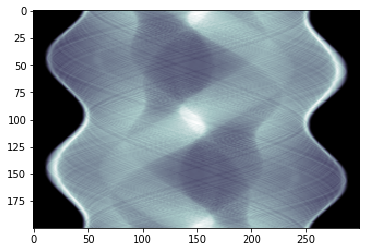

In [106]:
im = Image.open("data/sinogram_2d_spherical.tif")
sinogram_sp = np.array(im)
plt.imshow(sinogram_sp,cmap=plt.cm.bone)

**Step 2.3 :** Apply the spherical reconstruction function to the spherical sinogram and display the result

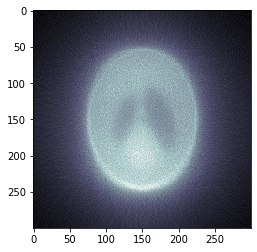

In [77]:
phantom_size=500
phantom = reconstruct_sp(sinogram_sp,[phantom_size,phantom_size])
plt.imshow(phantom,cmap=plt.cm.bone)
plt.show()

## 3) Spherical 3D reconstruction (3pts + 1pt for performances)

Now we are going to extend this algorithm to 3D.

Going from 2D to 3D means that a lot more computations have to be done. 
Using only python for-loop for the 3D reconstruction will be very slow. It's recommended to use as much as possible the numpy functions to avoid having to use too many for-loop.

<img src="notebook_images/projection_3d_cone.jpg" alt="Projection 3D spherical" style="height: 20em;"/>

 **Step 3.0 :** Write a function that return the coordinates of all voxels between two points in a 3D grid
 

In [104]:


def drawLine3D(x1, y1, z1, x2, y2, z2): 
	ListOfPoints = [] 
	ListOfPoints.append((x1, y1, z1)) 
	dx = abs(x2 - x1) 
	dy = abs(y2 - y1) 
	dz = abs(z2 - z1) 
	if (x2 > x1): 
		xs = 1
	else: 
		xs = -1
	if (y2 > y1): 
		ys = 1
	else: 
		ys = -1
	if (z2 > z1): 
		zs = 1
	else: 
		zs = -1

	# Driving axis is X-axis" 
	if (dx >= dy and dx >= dz):		 
		p1 = 2 * dy - dx 
		p2 = 2 * dz - dx 
		while (x1 != x2): 
			x1 += xs 
			if (p1 >= 0): 
				y1 += ys 
				p1 -= 2 * dx 
			if (p2 >= 0): 
				z1 += zs 
				p2 -= 2 * dx 
			p1 += 2 * dy 
			p2 += 2 * dz 
			ListOfPoints.append((x1, y1, z1)) 

	# Driving axis is Y-axis" 
	elif (dy >= dx and dy >= dz):	 
		p1 = 2 * dx - dy 
		p2 = 2 * dz - dy 
		while (y1 != y2): 
			y1 += ys 
			if (p1 >= 0): 
				x1 += xs 
				p1 -= 2 * dy 
			if (p2 >= 0): 
				z1 += zs 
				p2 -= 2 * dy 
			p1 += 2 * dx 
			p2 += 2 * dz 
			ListOfPoints.append((x1, y1, z1)) 

	# Driving axis is Z-axis" 
	else:		 
		p1 = 2 * dy - dz 
		p2 = 2 * dx - dz 
		while (z1 != z2): 
			z1 += zs 
			if (p1 >= 0): 
				y1 += ys 
				p1 -= 2 * dz 
			if (p2 >= 0): 
				x1 += xs 
				p2 -= 2 * dz 
			p1 += 2 * dy 
			p2 += 2 * dx 
			ListOfPoints.append((x1, y1, z1)) 
	return ListOfPoints 



In [120]:
x = [1,2,0]
y = [10,20,0]
print(drawLine3D(x[0],x[1],x[2],y[0],y[1],y[2]))

[(1, 2, 0), (2, 3, 0), (2, 4, 0), (3, 5, 0), (3, 6, 0), (4, 7, 0), (4, 8, 0), (5, 9, 0), (5, 10, 0), (6, 11, 0), (6, 12, 0), (7, 13, 0), (7, 14, 0), (8, 15, 0), (8, 16, 0), (9, 17, 0), (9, 18, 0), (10, 19, 0), (10, 20, 0)]


**Step 3.1 :** Write a function that take as argument a coordinate on a projection and an angle (and possibly other parameters to represent the geometry) and return the start and end of the path between this pixel and the source in a 3D spherical geometry.

In [119]:
def get_valid_points(pathCor,shape):
    filteredList=[]
    for p in pathCor:
        if p[0]<=shape[0] and p[1]<=shape[1] and p[2]<=shape[0]:
            filteredList.append(p)
    return filteredList


**Step 3.2 :** Create a function that take as argument a list of projection and the needed parameters, and output the result of the 3D spherical back-projection.

In [15]:
 import math
 from IPython import display

 def add_offset(point,offset):
    x1, y1,z1 = point
    x1+=offset
    y1+=offset
    z1+=offset
    return [x1,y1,z1]
 
 
 def reconstruct_sp(sinogram,phantom_size=[100,100,100]):
    SO=400
    OD=3600
    detector_len = sinogram.shape[1]
    phantom =np.zeros(phantom_size)
    for i in range(sinogram.shape[0]):
        angle_step = np.deg2rad(360/sinogram.shape[0])*i

        for element in range(detector_len):
            for j in range(sinogram.shape[2]):
        
            dis = np.floor((detector_len/2)-element)

            source_point=[np.round(-SO*np.cos(angle_step)),np.round(-SO*np.sin(angle_step)),j]

            int_point=[np.round(dis*np.cos(angle_step+np.pi/2)),np.round(dis*np.sin(angle_step+np.pi/2)),j]

            detector_CenterPoint=[np.round(OD*np.cos(angle_step)),np.round(OD*np.sin(angle_step)),j]
            

            detector_point=np.array(int_point)+np.array(detector_CenterPoint)

            # slope=(source_point[1]-detector_point[1])/(source_point[0]-detector_point[0])
            # calculated_angle=np.deg2rad(math.degrees(math.atan(slope)))
            # point_start,point_end = draw_line(detector_point,calculated_angle,150,150)

            
            pathCor=get_cells(add_offset(source_point,0),add_offset(detector_point,0))

            
            for p in pathCor:
                phantom[int(p[0]),int(p[1]),j]+=sinogram[i,element,j]

    return phantom



FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data/3d_projections/'

**Step 3.3 : ** Open all the tiff files in "data/3d_projections/"

The parameters of this dataset are the following :

 - Spherical aqcuisition geometry
 - The source, the rotation axis and the detector are all aligned
 - 200 projections over 360 degrees
 - Distance source-object : 200mm
 - Distance source-detector : 2000mm
 - Pixel size : 0.5mm by 0.5mm

(200, 128, 128)


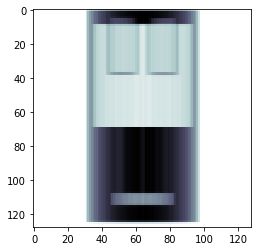

In [145]:
import os 
dirname = 'data/projections'
final = []
for fname in os.listdir(dirname):
    im = Image.open(os.path.join(dirname, fname))
    imarray = np.array(im)

    final.append(imarray)

final = np.asarray(final) 
final = np.moveaxis(final, [2, 0], [2, 0])
print(final.shape)
plt.imshow(final[125,:,:],cmap=plt.cm.bone)

**Step 3.4 :** Apply the function to the dataset and display the result of an arbitrary layer

In [316]:
DISPLAYED_LAYER_INDEX = 64

...

Ellipsis